In [ ]:
# WandB – Install the W&B library
!pip install wandb -q

In [3]:
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
wandb.init(project="MARRtino-face-mask-recognition", entity="ludocomito")

wandb: Currently logged in as: ludocomito. Use `wandb login --relogin` to force relogin


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([

        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

data_dir = '../input/face-mask-detection/Dataset'

dataset=torchvision.datasets.ImageFolder(data_dir,transform=data_transforms)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 8982
    Root location: ../input/face-mask-detection/Dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [7]:
train_set_size = int(len(dataset)*0.8)
val_set_size = len(dataset) - train_set_size
train, val = torch.utils.data.random_split(dataset, [train_set_size,val_set_size])

## We need to define loaders for the train and validation datasets

In [8]:
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=True)


In [10]:
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {"train": len(train), "val":len(val)}

In [11]:
dataloaders["train"]

In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 128, 128])
torch.Size([64])


## Defining an helper function that shows the batch of images

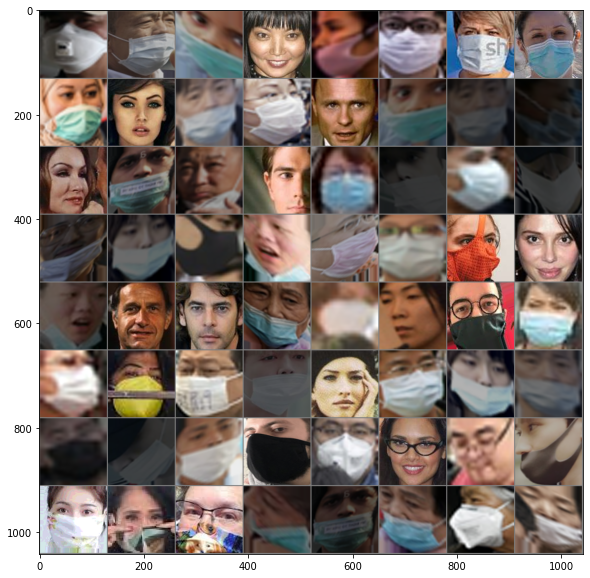

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [14]:
print(dataset.class_to_idx)

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    wandb.watch(model, criterion, log="all", log_freq=10)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #send data to W&B
            train_log(epoch_loss, epoch_acc,epoch,phase)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [16]:
def train_log(loss, acc, epoch, phase):
    loss = float(loss)
    acc = float(acc)
    
    if phase == 'train':
        wandb.log({"Epoch":epoch, "Training loss":loss, "Training accuracy": acc})
    else:
        wandb.log({"Epoch":epoch, "Validation loss":loss, "Validation accuracy": acc})

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
class_names = dataset.classes
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2543 Acc: 0.9070
val Loss: 0.0529 Acc: 0.9866

Epoch 1/24
----------
train Loss: 0.0428 Acc: 0.9893
val Loss: 0.0293 Acc: 0.9933

Epoch 2/24
----------
train Loss: 0.0186 Acc: 0.9961
val Loss: 0.0201 Acc: 0.9944

Epoch 3/24
----------
train Loss: 0.0123 Acc: 0.9979
val Loss: 0.0161 Acc: 0.9955

Epoch 4/24
----------
train Loss: 0.0080 Acc: 0.9997
val Loss: 0.0143 Acc: 0.9967

Epoch 5/24
----------
train Loss: 0.0072 Acc: 0.9992
val Loss: 0.0146 Acc: 0.9972

Epoch 6/24
----------
train Loss: 0.0045 Acc: 1.0000
val Loss: 0.0130 Acc: 0.9967

Epoch 7/24
----------
train Loss: 0.0046 Acc: 0.9997
val Loss: 0.0140 Acc: 0.9967

Epoch 8/24
----------
train Loss: 0.0048 Acc: 0.9994
val Loss: 0.0135 Acc: 0.9978

Epoch 9/24
----------
train Loss: 0.0038 Acc: 0.9997
val Loss: 0.0145 Acc: 0.9961

Epoch 10/24
----------
train Loss: 0.0037 Acc: 0.9999
val Loss: 0.0142 Acc: 0.9972

Epoch 11/24
----------
train Loss: 0.0037 Acc: 0.9997
val Loss: 0.0123 Acc: 0.9967

Ep

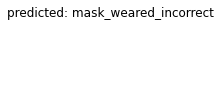

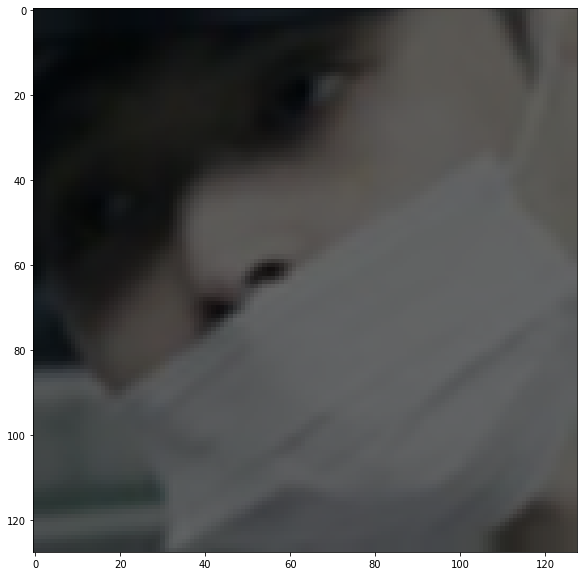

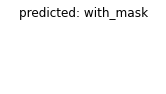

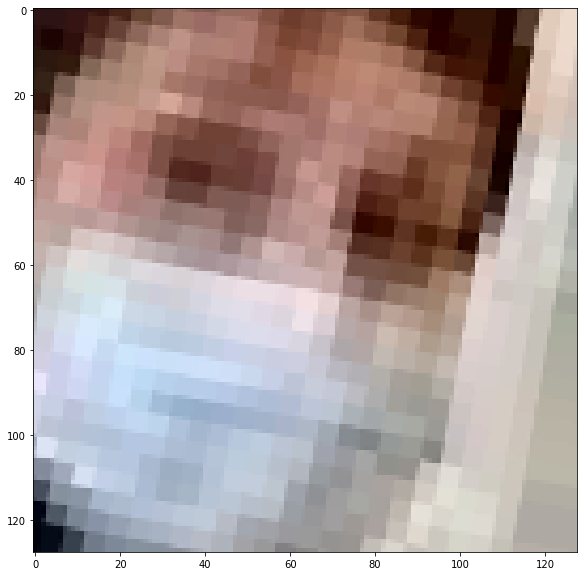

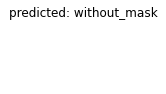

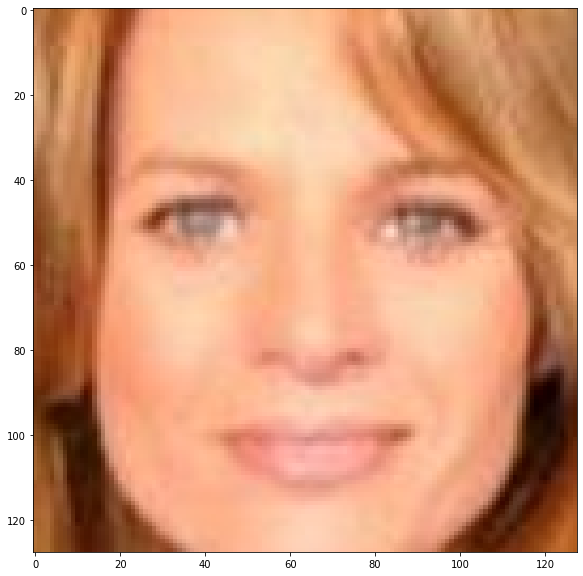

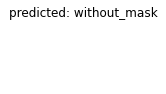

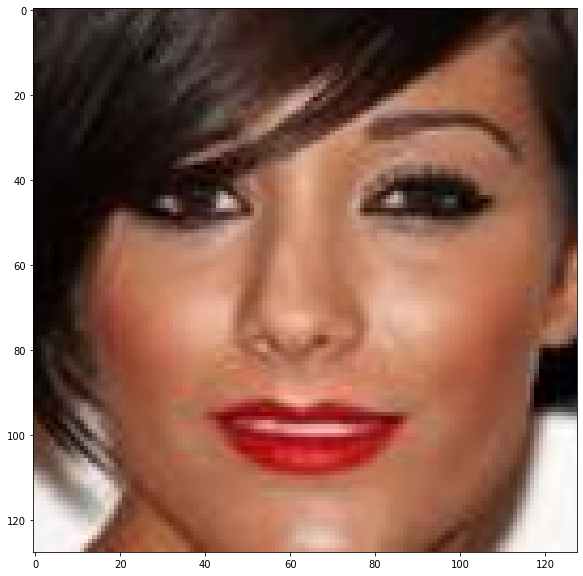

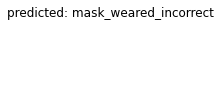

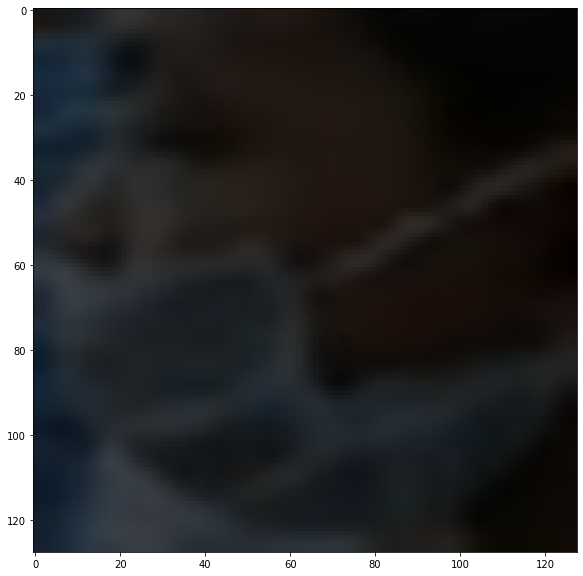

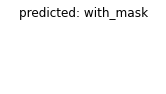

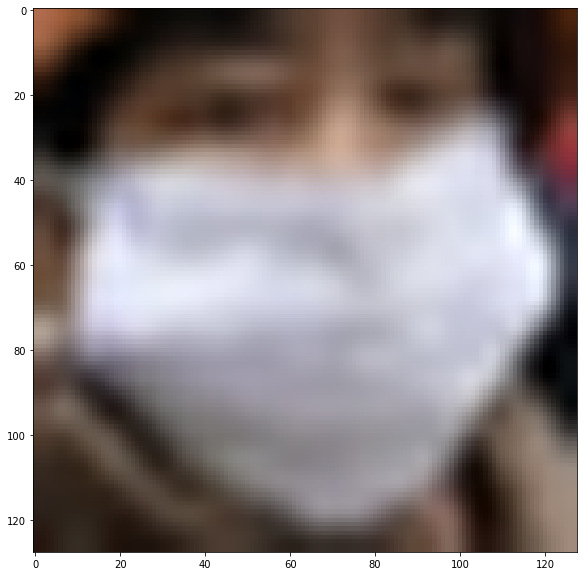

In [21]:
visualize_model(model_ft)

In [25]:
torch.save(model_ft.state_dict(), 'mask_recognition_model.pth')